In [37]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
from scipy.stats import entropy
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
pd.set_option('display.max_columns', None)

df_table = pq.read_table("transaction_fraud_data.parquet")
rates_table = pq.read_table("historical_currency_exchange.parquet")
df = df_table.to_pandas()
rates = rates_table.to_pandas()

In [39]:
# Коэффициент, во сколько раз реальный датасет фрагмента (для приближения абсолютных значений к реальной ситуации)
a = 70
# Обработка части датасета, чтобы код работал быстрее
df = df.sample(round(df.shape[0]/a))

## Финальное описание фичей (вместе со сгенерированными фичами, можно посмотреть в файле eda.ipynb)

| Поле | Описание | Тип |
|------|----------|-----|
| `uid` | Уникальный идентификатор транзакции | String | 
| `transaction_id` | Уникальный идентификатор транзакции | String | 
| `customer_id` | Уникальный идентификатор клиента | String | 
| `card_number` | Маскированный номер карты | Int64 |
| `timestamp` | Дата и время транзакции | Datetime(time_unit='us') |
| `vendor_category` | Общая категория вендора (например, Розница, Путешествия) | String |
| `vendor_type` | Тип вендора внутри категории (например, "онлайн") | String |
| `vendor` | Название вендора | String |
| `amount` | Сумма транзакции | Float64 |
| `amount_usd` | Сумма транзакций в долларах США | Float64 |
| `rate_to_usd` | Отношение национальной валюты к доллару на день расчетов | Float64 |
| `currency` | Валюта (например, USD, EUR, JPY) | String |
| `country` | Страна, где проведена транзакция | String |
| `city` | Город, где проведена транзакция | String |
| `city_size` | Размер города (например, средний, крупный) | String |
| `card_type` | Тип карты (например, Basic Credit, Gold Credit) | String |
| `is_card_present` | Присутствовала ли карта физически при оплате (POS) | Boolean |
| `device` | Устройство, с которого проведена транзакция (например, Chrome, iOS App) | String |
| `channel` | Канал проведения транзакции (веб, мобильный, POS) | String |
| `device_fingerprint` | Уникальный отпечаток устройства | String |
| `ip_address` | IP-адрес транзакции | String | 
| `is_outside_home_country` | Признак того, что операция проведена вне страны клиента | Boolean |
| `is_high_risk_vendor` | Является ли категория вендора рискованной (например, Путешествия, Развлечения) | Boolean |
| `is_weekend` | Произошла ли операция в выходной день | Boolean |
| `is_fraud` | Является ли транзакция мошеннической (`True` / `False`) | Boolean |
| `last_hour_num_transactions` | Кол-во транзакций, совершённых этим клиентом за последний час до данной транзакции | Int64 |
| `last_hour_total_amount` | Сумма всех этих транзакций за последний час | Float64 |
| `last_hour_unique_merchants` | Кол-во разных продавцов (vendor), у которых клиент платил за последний час | Int64 |
| `last_hour_unique_countries` | Кол-во разных стран, где клиент провёл транзакции за этот час | Int64 |
| `last_hour_max_single_amount` | Самая крупная транзакция клиента за час до текущей | Float64 |
| `last_hour_total_amount_usd` | Сумма транзакций за последний час в долларах США | Float64 |
| `last_hour_max_single_amount_usd` | Самая крупная транзакция клиента за час до текущей в долларах США | Float64 |
| `hour` | Час, в который произведена транзакция | int32 |
| `day` | День месяца | int32 |
| `date` | Дата | Datetime |
| `weekday_name` | День недели | object |
| `is_night_operation` | Произведена ли транзакция в ночное время | int64 |
| `customer_avg_amount` | Средняя сумма транзакций клиента | float64 |
| `customer_std_amount` | Стандартное отклонение суммы транзакций | float64 |
| `customer_txn_count` | Общее число транзакций клиента за всё время | int64 |
| `customer_vendor_entropy` | Энтропия по вендорам (разнообразие покупок) | float64 |
| `customer_device_count` | Кол-во уникальных устройств у клиента | int64 |
| `customer_country_count` | Кол-во стран, в которых клиент совершал транзакции | int64 |
| `customer_card_type_variety` | Кол-во разных типов карт у клиента | int64 |
| `customer_avg_hour` | Среднее время совершения сделки клиентом | float64 |
| `is_new_device_for_customer` | Транзакци произведена с нового для клиента устройства | int64 |
| `is_new_city_for_customer` | Транзакци произведена из нового для клиента города | int64 |
| `is_device_shared` | устройство трназакции используется несколькоими клиентами | int64 |
| `ip_prev_fraud_count` | количество предыдущих мошеннических транзекций | int64 |
| `is_amount_outlier` | Флаг того, что транзакция на +- 2 страндартных отклонения отличается от средней на клиента | int64 |
| `amount_to_avg_ratio` | Отношение суммы текущей транзакции к средней сумме транзакций пользователя | float64 |
| `merchant_reuse` | Покупал ли клиент ранее у этого вендора | int64 |
| `customer_prev_fraud_count` | Кол-во фродовых транзакций клиента до текущей | int64 |
| `customer_prev_fraud_percent` | Доля фродовых транзакций среди всех предыдущих у клиента | float64 |

## Технические гипотезы

1. Наличие дисбаланса классов по целевой переменной

In [17]:
fraud_summary #count примерный, посколку используется часть датасета и апроксимируется на весь

,is_fraud,count,percent
0,not fraud,5998580,80.15
1,fraud,1485190,19.85


Фродовые операции составляют ~20% датасета, дисбаланс классов присутствует, но с ним можно работать

2. Поле 'transaction_id', как было замечено ранее, не уникалькально. При этом полного дублирования строк нет (у транзакций разные customer_id)

In [20]:
df['transaction_id'].value_counts().head()

transaction_id
TX_9c2d174f    3
TX_eef2ac1b    3
TX_4e6f041a    3
TX_891636c5    3
TX_706baadf    3
Name: count, dtype: int64

In [21]:
df[['transaction_id', 'customer_id']].value_counts().head()

transaction_id  customer_id
TX_1d881541     CUST_34882     2
TX_000014c9     CUST_49417     1
TX_000016b6     CUST_37015     1
TX_000024a1     CUST_25843     1
TX_000026dd     CUST_26575     1
Name: count, dtype: int64

Возможные причины

1. Переиспользование идентификаторов
Система могла генерировать transaction_id заново для каждой сессии, устройства или среды (например, тестовая и боевая среда, разные страны, оффлайн/онлайн).

Или transaction_id уникален в рамках одного вендора, но не глобально.

2. Атаки или подозрительная активность
Это может быть след фрода:

клоны транзакции с мелкими отличиями (IP, amount),

попытка подмены устройства или маскировки через дубли.


Корреляция с is_fraud:
is_new_device_for_customer    0.573422
is_night_operation            0.373447
amount_usd                    0.225250
amount                        0.202065
amount_to_avg_ratio           0.167833
is_amount_outlier             0.167280
rate_to_usd                   0.143314
customer_device_count         0.125442
is_device_shared              0.124847
customer_std_amount           0.054466
dtype: float64


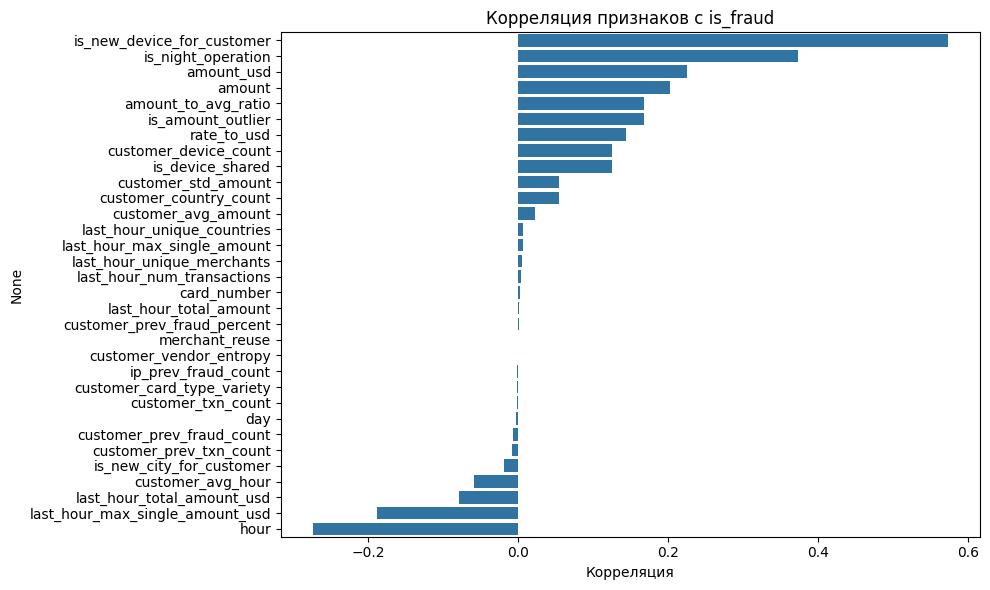

In [27]:
# Корреляция is_fraud с числовыми признаками
numeric_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
if 'is_fraud' in numeric_cols:
    numeric_cols = numeric_cols.drop('is_fraud')  # исключаем is_fraud, чтобы не сравнивать сам с собой

correlations = df[numeric_cols].corrwith(df['is_fraud']).sort_values(ascending=False)
print("\nКорреляция с is_fraud:")
print(correlations.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index)
plt.title("Корреляция признаков с is_fraud")
plt.xlabel("Корреляция")
plt.tight_layout()
plt.show()

# Поиск мультиколлинеарности между признаками
corr_matrix = df[numeric_cols].corr().abs()

# Отбираем пары с корреляцией > 0.95 (без дубликатов и самих себя)
high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={0: 'correlation', 'level_0': 'feature_1', 'level_1': 'feature_2'})
)

C:\Users\test\AppData\Local\Temp\ipykernel_10100\3077358812.py:16: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

c:\Users\test\anaconda3\envs\rag_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



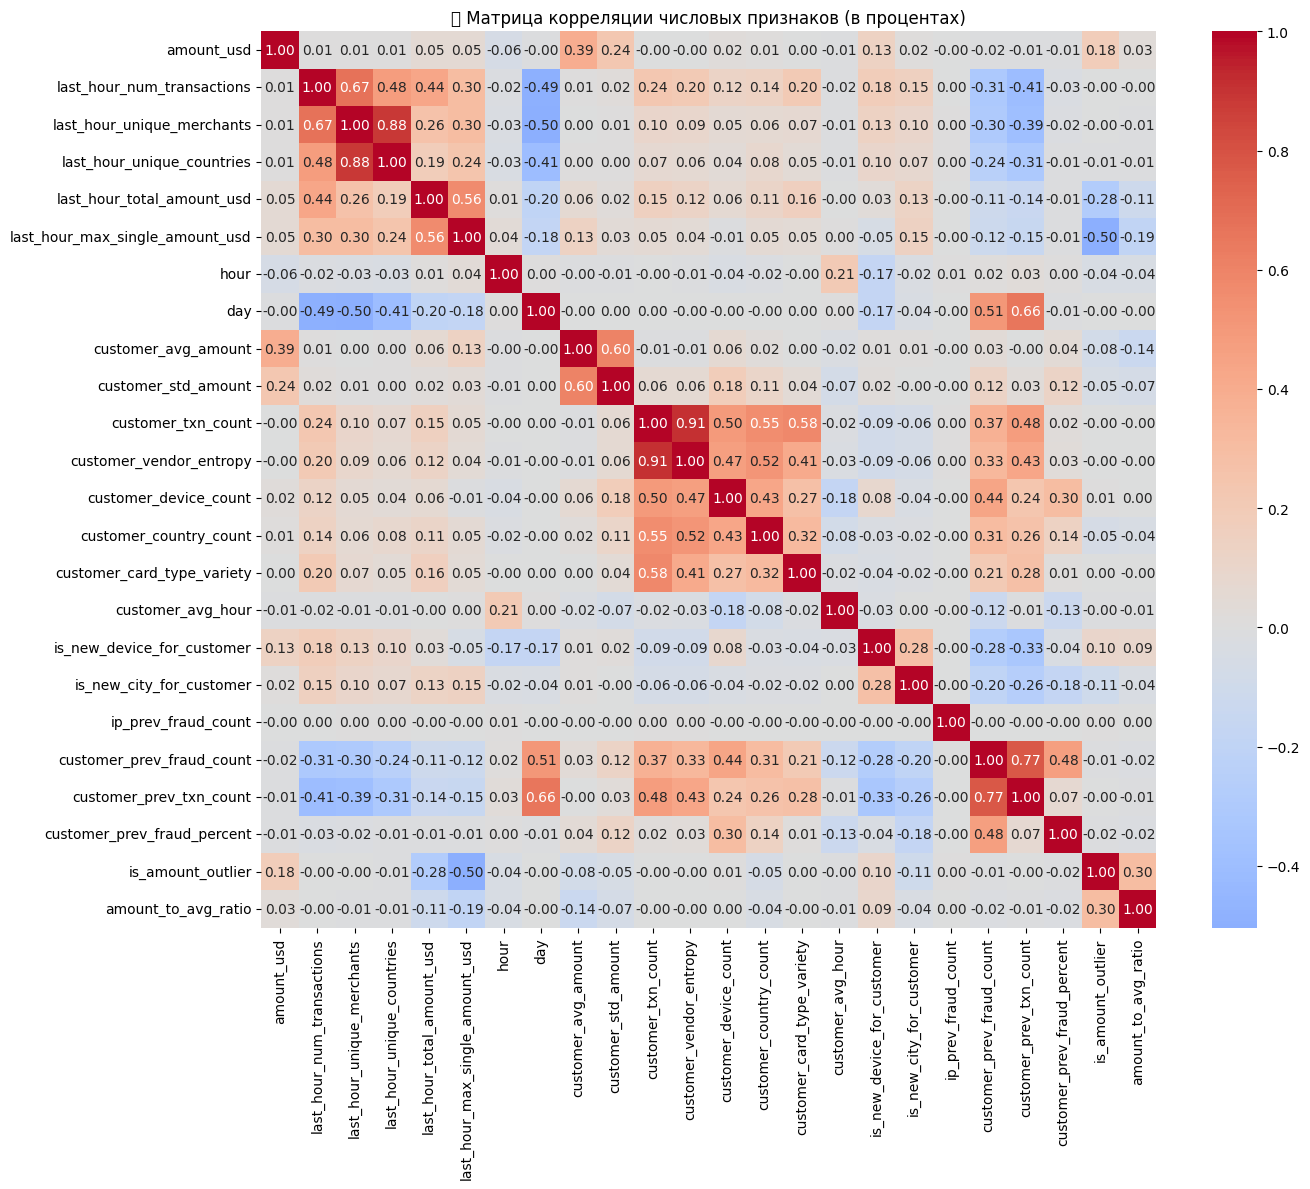

In [33]:
exclude_columns = ['card_number', 'rate_to_usd', 'amount', 'is_amount_outer', 'is_night_operation', 'last_hour_total_amount', 'last_hour_max_single_amount', 'merchant_reuse', 'is_device_shared']
filtered_cols = [col for col in numeric_cols if col not in exclude_columns]

corr_matrix = df[filtered_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    center=0
)
plt.title("Матрица корреляции числовых признаков (в процентах)")
plt.tight_layout()
plt.show()

In [53]:
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Выбираем только те пары, где корреляция > 0.75
high_corr_pairs = (
    upper_triangle
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'correlation'})
    .query('abs(correlation) > 0.75')
    .sort_values(by='correlation', ascending=False)
)

print("Пары признаков с |корреляцией| > 0.75:")
display(high_corr_pairs)

Пары признаков с |корреляцией| > 0.75:


,feature_1,feature_2,correlation
175,customer_txn_count,customer_vendor_entropy,0.903634
43,last_hour_unique_merchants,last_hour_unique_countries,0.882326
243,customer_prev_fraud_count,customer_prev_txn_count,0.771287


Коррелирующих признаков практически нет

*Также можно дополнительно проверить категориальные признаки

## Продуктовые гипотезы 

**1. Ночные транзакции — чаще фрод**

Гипотеза: Транзакции, совершённые ночью (например, с 00:00 до 05:00), имеют большую вероятность быть мошенническими

Метрика: % фрода в в разное время суток

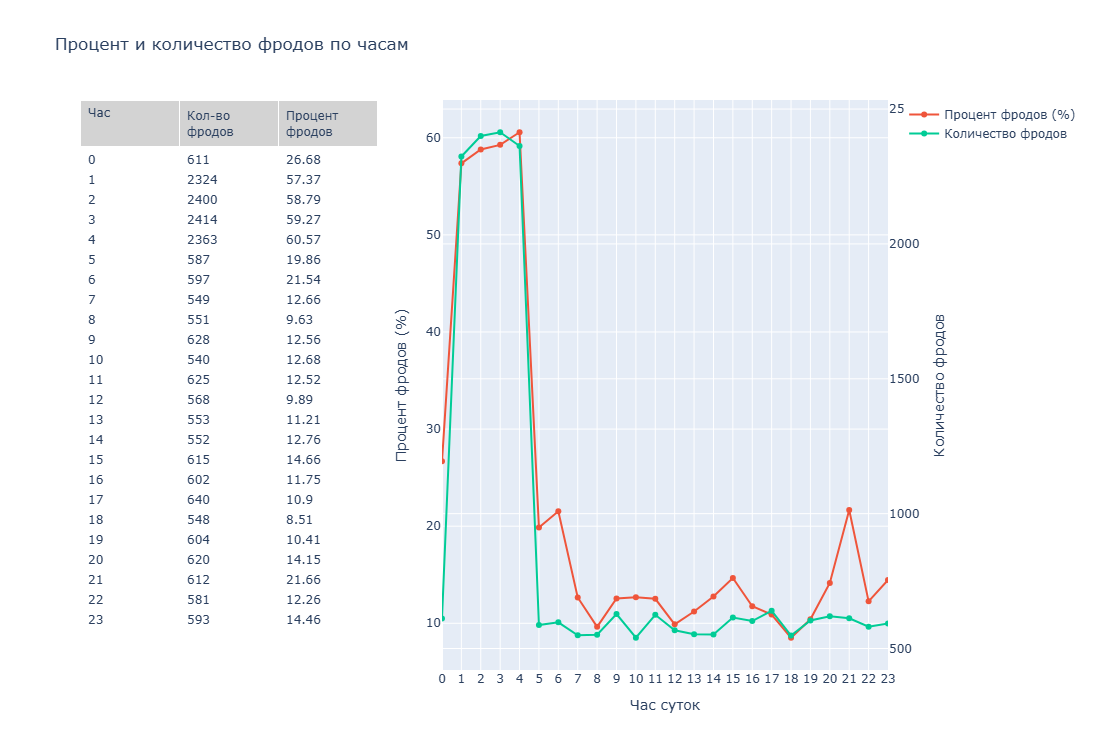

In [30]:
# Подсчёт количества фродов и всех транзакций по каждому часу
fraud_by_hour = (
    df.groupby('hour')['is_fraud']
    .agg(
        fraud_count=lambda x: (x == True).sum(),
        total_count='count'
    )
    .reset_index()
)

# Расчёт процента фрода
fraud_by_hour['fraud_percent'] = (
    fraud_by_hour['fraud_count'] / fraud_by_hour['total_count'] * 100
).round(2)

# Сортировка по часам
fraud_by_hour = fraud_by_hour.sort_values('hour')

# Убедимся, что таблица содержит все 24 часа
all_hours = pd.DataFrame({'hour': range(24)})
fraud_by_hour_full = all_hours.merge(fraud_by_hour, on='hour', how='left')

# Заполним отсутствующие значения нулями
fraud_by_hour_full['fraud_count'] = fraud_by_hour_full['fraud_count'].fillna(0).astype(int)
fraud_by_hour_full['total_count'] = fraud_by_hour_full['total_count'].fillna(0).astype(int)
fraud_by_hour_full['fraud_percent'] = fraud_by_hour_full.apply(
    lambda row: (row['fraud_count'] / row['total_count'] * 100) if row['total_count'] > 0 else 0,
    axis=1
).round(2)
fig = go.Figure()

# Создаём подграфики: таблица + график
fig = sp.make_subplots(
    rows=1, cols=2,
    column_widths=[0.4, 0.6],
    specs=[[{"type": "table"}, {"type": "xy"}]],
    horizontal_spacing=0.08,
    shared_xaxes=False
)

# Таблица слева
fig.add_trace(
    go.Table(
        header=dict(values=['Час', 'Кол-во фродов', 'Процент фродов'],
                    fill_color='lightgrey', align='left'),
        cells=dict(values=[
            fraud_by_hour_full['hour'],
            fraud_by_hour_full['fraud_count'],
            fraud_by_hour_full['fraud_percent']
        ],
        fill_color='white', align='left')
    ),
    row=1, col=1
)
# Линия 1: процент фрода (левая ось)
fig.add_trace(go.Scatter(
    x=fraud_by_hour_full['hour'],
    y=fraud_by_hour_full['fraud_percent'],
    mode='lines+markers',
    name='Процент фродов (%)',
    yaxis='y1'
))

# Линия 2: количество фродов (правая ось)
fig.add_trace(go.Scatter(
    x=fraud_by_hour_full['hour'],
    y=fraud_by_hour_full['fraud_count'],
    mode='lines+markers',
    name='Количество фродов',
    yaxis='y2'
))

# Настройки макета
fig.update_layout(
    title='Процент и количество фродов по часам',
    xaxis=dict(
        title='Час суток',
        tickmode='linear',
        dtick=1,
        range=[0, 23]
    ),
    yaxis=dict(
        title='Процент фродов (%)',
        side='left'
    ),
    yaxis2=dict(
        title='Количество фродов',
        overlaying='y',
        side='right'
    ),
    height=750,
    width=1000
)

fig.show()

На графике видно, что фрод-процент ночью превышает 60%, в то время как днём он падает ниже 15%.

**Возможные причины:**

- Пользователи менее внимательны ночью

- Боты и автоматизированные атаки часто запускаются в это время

- Ночью слабее работает внутренняя система контроля и мониторинга

- Ночью в целом меньше не моеннических транзакций, это способствует относительному росту доли мошеннических

Метрика для валидации:

**fraud_rate_night** = (фрод с 0:00–5:00) / (все транзакции с 0:00–5:00)

Для построения моделей может пригодиться фича **is_night_operation** (добавлена выше)

**2. Новые пользователи подвержены большему риску мошенничества**

Гипотеза: У недавно зарегистрированных пользователей выше доля мошеннических операций, особенно в первые дни после регистрации.

Метрика: % фрода среди пользователей, совершающих первую транзакцию.

In [84]:
# Сортируем транзакции по клиенту и времени
df_sorted = df.sort_values(by=['customer_id', 'timestamp'])

# Добавляем флаг: первая ли это транзакция клиента
df_sorted['is_first_txn'] = df_sorted.groupby('customer_id').cumcount() == 0

# Считаем количество фродов среди первых и не первых транзакций
fraud_by_first_flag = (
    df_sorted.groupby('is_first_txn')['is_fraud']
    .agg(
        fraud_count=lambda x: (x == True).sum(),
        total_count='count'
    )
    .reset_index()
)

# Добавим долю фрода
fraud_by_first_flag['fraud_percent'] = (
    fraud_by_first_flag['fraud_count'] / fraud_by_first_flag['total_count'] * 100
).round(2)

# Приводим признак к строковому виду для читаемости
fraud_by_first_flag['txn_type'] = fraud_by_first_flag['is_first_txn'].map({
    True: 'Первая транзакция',
    False: 'Повторная транзакция'
})

# Финальная таблица
fraud_by_first_flag = fraud_by_first_flag[['txn_type', 'fraud_count', 'total_count', 'fraud_percent']]
fraud_by_first_flag

,txn_type,fraud_count,total_count,fraud_percent
0,Повторная транзакция,19018,95131,19.99
1,Первая транзакция,1073,4869,22.04


Фрод среди первых транзакций действительно выше — 22.04% против 19.99%.

Это подтверждает гипотезу в общем виде.

Такой результат может быть обусловлен следующими факторами:

- небольшая относительная доля первых транзакций (всего ~5% от общего объёма);

- короткий жизненный цикл "мошеннических клиентов" — они совершают 1–2 транзакции и исчезают

**Вывод:**

Гипотеза частично подтверждается - первые транзакции действительно более рискованные, чем повторные. Это может быть связано с тем, что мошенники создают новые аккаунты для каждой атаки. Однако гипотеза требует дополнительной проверки на статистическую значимость, а также анализа по дням с момента регистрации

**3. Фродовые транзакции чаще совершаются с новых устройств**

Гипотеза: Если операция совершается с ранее неизвестного устройства для пользователя, это повышает риск фрода

Метрика: Доля фродовых транзакций с новым device_id

In [85]:
device_fraud_table = (
    df.groupby('is_new_device_for_customer')['is_fraud']
    .agg(
        fraud_count=lambda x: (x == True).sum(),
        total_count='count'
    )
    .reset_index()
)

device_fraud_table['fraud_percent'] = (
    device_fraud_table['fraud_count'] / device_fraud_table['total_count'] * 100
).round(2)

device_fraud_table.columns = ['is_new_device_for_customer', 'fraud_count', 'total_count', 'fraud_percent']
display(device_fraud_table)

,is_new_device_for_customer,fraud_count,total_count,fraud_percent
0,0,5240,75241,6.96
1,1,14851,24759,59.98


**Вывод:**
- Почти 60% всех транзакций, совершённых с новых устройств, оказались фродовыми — это в 8.6 раз выше, чем при использовании уже известных устройств.
- Это очень сильный сигнал о том, что новое устройство — мощный индикатор потенциального мошенничества.
- Внедрение этой фичи в antifraud-модель может существенно повысить её точность и способность выявлять рискованные транзакции.

**Польза для разработки:**
- Включить **is_new_device_for_customer** в модель как бинарный признак.
- Можно дополнительно отслеживать транзакции с новых устройств в реальном времени для усиленного контроля или автоматической приостановки.
- Можно усилить фичу, добавив время с момента последнего использования старого устройства или расстояние между геолокациями устройств.

**4. Новая геолокация - признак фрода**

Гипотеза: Если транзакция осуществляется из региона, где пользователь ранее не был, вероятность фрода возрастает

Метрика:% is_fraud в новой локации

In [87]:
city_fraud_table = (
    df.groupby('is_new_city_for_customer')['is_fraud']
    .agg(
        fraud_count=lambda x: (x == True).sum(),
        total_count='count'
    )
    .reset_index()
)

city_fraud_table['fraud_percent'] = (
    city_fraud_table['fraud_count'] / city_fraud_table['total_count'] * 100
).round(2)

city_fraud_table.columns = ['is_new_city_for_customer', 'fraud_count', 'total_count', 'fraud_percent']
display(city_fraud_table)

,is_new_city_for_customer,fraud_count,total_count,fraud_percent
0,0,18416,90708,20.30
1,1,1675,9292,18.03


**Вывод:**
- Гипотеза не подтверждается.
- Доля мошенничества в новой геолокации **(18.03%)** ниже, чем в уже известных пользователю городах **(20.30%)**
Это контринтуитивный результат, который может указывать на одну из следующих причин:
- Пользователи сами активно перемещаются
- Мошенники чаще используют сохранённые "старые" локации, чтобы не вызывать подозрений

**5. Мошенничество концентрируется вокруг определённых вендоров**

Гипотеза: Некоторые торговые точки чаще используются для фрода, возможно, из-за слабых проверок или сговора

Метрика: Доля фрода у вендора

In [ ]:
vendor_fraud_table = (
    df.groupby('vendor')['is_fraud']
    .agg(
        fraud_count=lambda x: x.sum(),
        total_count='count'
    )
    .reset_index()
)

vendor_fraud_table['fraud_percent'] = (
    vendor_fraud_table['fraud_count'] / vendor_fraud_table['total_count'] * 100
).round(2)
vendor_types = df[['vendor', 'vendor_type']].drop_duplicates()
vendor_fraud_table = vendor_types.merge(vendor_fraud_table, on='vendor', how='left')
vendor_fraud_table = vendor_fraud_table.sort_values('fraud_percent', ascending=False)

top20 = vendor_fraud_table.head(20)
bottom20 = vendor_fraud_table.tail(20)

html = f"""
<div style="display: flex; gap: 50px;">
    <div>
        <h3>Топ 20 вендоров по % мошеннических операций</h3>
        {top20.to_html(index=False)}
    </div>
    <div>
        <h3>Топ 20 вендоров по минимальному % мошеннических операций</h3>
        {bottom20.to_html(index=False)}
    </div>
</div>
"""

display(HTML(html))

vendor,vendor_type,fraud_count,total_count,fraud_percent
HBO Max,streaming,135,579,23.32
AliExpress,online,201,879,22.87
eBay,online,202,886,22.80
Amazon Prime,streaming,147,646,22.76
Airbnb,booking,136,602,22.59
Instacart,online,349,1567,22.27
Steam,gaming,195,882,22.11
Best Buy,physical,171,775,22.06
Taco Bell,fast_food,151,687,21.98
Ticketmaster,events,182,829,21.95


**Топ-20 вендоров с наибольшим уровнем фрода:**
- Средняя доля фрода у топ-20 — **22.1%**, что значительно выше среднего по всей выборке.
- Наиболее подверженные категории: online-платформы, стрименговые сервисы, туризм (бронирование, транспорт, отели), игры
- HBO Max, AliExpress, eBay, Amazon Prime, Airbnb — лидеры по частоте фрода. Это преимущественно онлайн-сервисы, работающие по подписке или с моментальными транзакциями. У многих из них слабая верификация личности и возможность создания временных аккаунтов.

**Вендоры с наименьшим уровнем фрода:**
- В среднем имеют ~**18.1%** фродов — ниже, чем топ-20, на 4 процентных пунктов.
- Это в основном оффлайн-точки и крупные розничные магазины (Texaco, Newegg, Red Lobster, Publix и т.д.).

**Выводы и интерпретация**
- Фрод действительно концентрируется вокруг определённых вендоров.
- Онлайн-платформы, особенно с подписками и цифровыми продуктами, более подвержены фроду. Торговые точки с высокой степенью автоматизации и низкой проверкой — в зоне риска.
- Вендоры из категории **'is_high_risk_vendor'** встречаются как в топе по количеству мошеннических операций - 12, так и в хвосте - 7

**Идеи для продуктовой и технической доработки**
- Ранжировать вендоров по риску и внедрить дополнительные проверки (например, OTP, верификация IP, гео).
- Для вендоров из топа — увеличить вес признака "вендор" в ML-моделях или добавить флаг is_high_risk_vendor_by_stats

**6. Определённые отрасли — мишени мошенников**

Гипотеза: В некоторых категориях продавцов (например, digital services или gaming) доля фродовых операций выше, чем в других

Метрика: Доля is_fraud по vendor_type

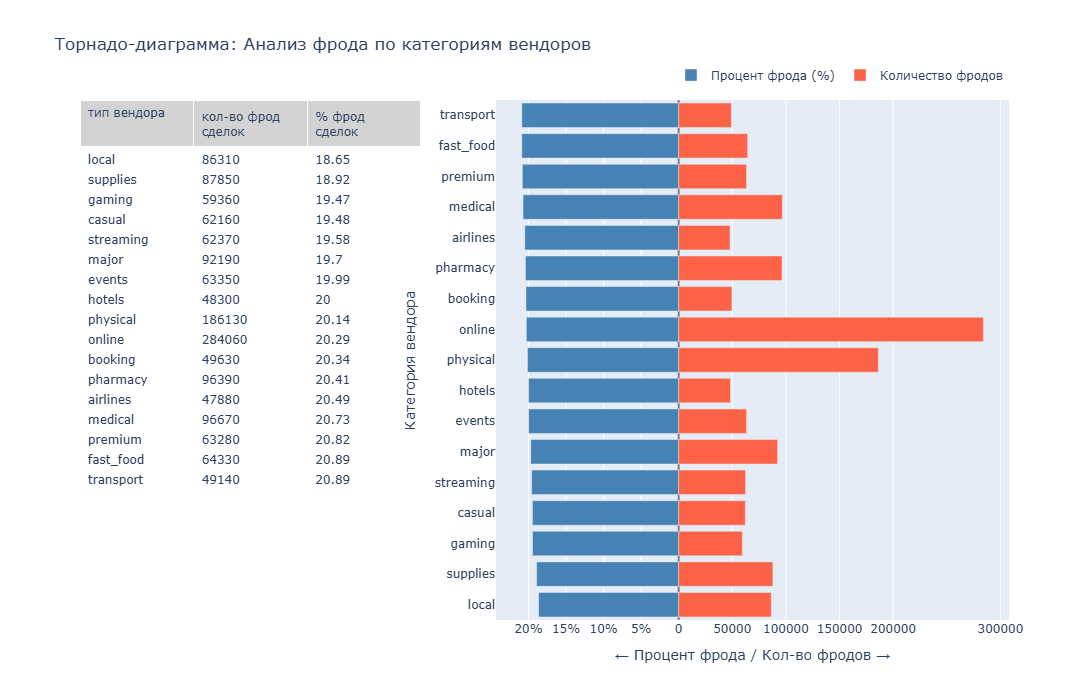

In [57]:
# Упорядочим по проценту фрода
fraud_rate_table = fraud_rate_table.sort_values('fraud_percent', ascending=True)
fig = go.Figure()

# Создаём подграфики: таблица + график
fig = sp.make_subplots(
    rows=1, cols=2,
    column_widths=[0.4, 0.6],
    specs=[[{"type": "table"}, {"type": "xy"}]],
    horizontal_spacing=0.08,
    shared_xaxes=False
)

# Таблица слева
fig.add_trace(
    go.Table(
        header=dict(values=['тип вендора', 'кол-во фрод сделок', '% фрод сделок'],
                    fill_color='lightgrey', align='left'),
        cells=dict(values=[
            fraud_rate_table['vendor_type'],
            fraud_rate_table['fraud_count'],
            fraud_rate_table['fraud_percent']
        ],
        fill_color='white', align='left')
    ),
    row=1, col=1
)

# Масштабируем процент фрода (×20) и инвертируем
fraud_rate_table['fraud_percent_neg_scaled'] = -fraud_rate_table['fraud_percent'] * 7000

# Левая часть — масштабированный процент фрода (×20)
fig.add_trace(go.Bar(
    x=fraud_rate_table['fraud_percent_neg_scaled'],
    y=fraud_rate_table['vendor_type'],
    orientation='h',
    name='Процент фрода (%)',
    marker_color='steelblue'
))

# Правая часть — количество фродов
fig.add_trace(go.Bar(
    x=fraud_rate_table['fraud_count'],
    y=fraud_rate_table['vendor_type'],
    orientation='h',
    name='Количество фродов',
    marker_color='tomato'
))

# Настраиваем график
fig.update_layout(
    title='Торнадо-диаграмма: Анализ фрода по категориям вендоров',
    barmode='relative',
    height=700,
    width=950,
    xaxis=dict(
        title='← Процент фрода / Кол-во фродов →',
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='gray',
        tickmode='array',
        tickvals=[-140000, -105000, -70000, -35000, 0, 50000, 100000, 150000, 200000, 2500000, 300000],
        ticktext=['20%', '15%', '10%', '5%', '0', '50000', '100000', '150000', '200000', '2500000', '300000']
    ),
    yaxis=dict(
        title='Категория вендора',
        automargin=True
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

Категории booking, transport, streaming и online выделяются как наиболее рискованные с точки зрения относительного процента фрода. Эти отрасли часто работают онлайн, допускают быструю оплату, бронирование и отмену — что удобно для злоумышленников.

Категория online — лидер по абсолютному количеству фродовых транзакций. Это говорит не только о повышенном риске, но и о масштабе воздействия.

**Выводы**
- определённые отрасли демонстрируют более высокую долю мошеннических операций (необходимо более детальное исследование)

при мониторинге Необходимо учитывать два фактора:
- долю мошеннических операций
- абсолютная количество мошеннических операций

**7. Повторные фродовые операции от одного и того же IP-адреса**

Гипотеза: Один и тот же IP часто используется для нескольких мошеннических операций.

Метрика: Кол-во фродовых транзакций по IP > 1

In [164]:
df[df['is_fraud'] == True]['ip_address'].value_counts().head(3)

ip_address
247.152.188.229    1
122.64.154.127     1
83.173.104.241     1
Name: count, dtype: int64

Все мошеннические операции совершаются с уникальных ip (стоит проверить на всем датасете)

**8. Несколько пользователей используют одну и ту же карту/устройство**

Гипотеза: Если одно и то же устройство или карта используется разными аккаунтами, это может свидетельствовать о мошенничестве

Метрики: Кол-во customer_id на одно device_id > 1
         Кол-во customer_id на одно card_id > 1

In [64]:
# Фрод-рейт по shared device
fraud_rate_shared_device = df[df["is_device_shared"] == 1]["is_fraud"].mean()
fraud_rate_nonshared_device = df[df["is_device_shared"] == 0]["is_fraud"].mean()

print(f" Процент мошеннических транзакций, если устройством пользуются разные клиенты: {fraud_rate_shared_device:.2f}")
print(f" Процент мошеннических транзакций, если у устройства один владелец: {fraud_rate_nonshared_device:.2f}")

 Процент мошеннических транзакций, если устройством пользуются разные клиенты: 1.00
 Процент мошеннических транзакций, если у устройства один владелец: 0.20


Каждая карта привязана только к одному клиенту (стоит проверить на всем датасете)

Процент мошеннических транзакций, совершенных с устройства у которого более 1 "владельца" стремится к 100% (стоит проверить на всем датасете)

Таким образом, гипотеза может быть реализована частично. У каждой карты один пользователь, но девайсы, принадлежащие разным клиентам - сигнал о потенциальной мошеннической операции

**9. Тип карты влияет на объем фрода**

Гипотеза: Мошенники чаще используют карты более низкого уровня (не Gold и Premium)

Метрика: % фрода по card_type

In [169]:
# Группировка по типу карты
fraud_by_card_type = (
    df.groupby('card_type')['is_fraud']
    .agg(['count', 'sum'])  # count — всего транзакций, sum — фродов
    .rename(columns={'count': 'total_txns', 'sum': 'fraud_txns'})
)

# Добавим долю фрода в процентах
fraud_by_card_type['fraud_rate (%)'] = (fraud_by_card_type['fraud_txns'] / fraud_by_card_type['total_txns'] * 100).round(2)

# Сброс индекса для читаемости
fraud_by_card_type = fraud_by_card_type.reset_index().sort_values('fraud_rate (%)', ascending=False)

# Вывод таблицы
print(fraud_by_card_type.to_string(index=False))

      card_type  total_txns  fraud_txns  fraud_rate (%)
  Premium Debit       20575        4166           20.25
    Gold Credit       19188        3872           20.18
   Basic Credit       18971        3822           20.15
    Basic Debit       20707        4156           20.07
Platinum Credit       20559        4075           19.82


Вывод: Тип карты не влияет на количество мошеннических операций

**10. Необычные суммы с копейками — попытка обмана**

Гипотеза: Если сумма транзакции неровная, вероятность мошенничества возрастает

Метрика: Частота фрода выше для сумм с мелкими дробными частями

In [150]:
# Выделим "неровные" суммы: дробная часть не равна 0.00 или 0.50
mask_irregular = ~df['amount'].mod(1).isin([0.00, 0.50])
fraud_rate_irregular = df.loc[mask_irregular, 'is_fraud'].mean()

# "Ровные" суммы: 0.00 или 0.50
mask_regular = df['amount'].mod(1).isin([0.00, 0.50])
fraud_rate_regular = df.loc[mask_regular, 'is_fraud'].mean()

# Базовый фрод-рейт
fraud_rate_baseline = df['is_fraud'].mean()

# Таблица результатов
metrics_amount_no_cols = pd.DataFrame({
    "Категория": [
        "Фрод-рейт (неровная сумма)",
        "Фрод-рейт (ровная сумма)",
        "Средний фрод-рейт"
    ],
    "Значение": [
        round(fraud_rate_irregular * 100, 2),
        round(fraud_rate_regular * 100, 2),
        round(fraud_rate_baseline * 100, 2)
    ]
})

# Вывод
print(metrics_amount_no_cols.to_string(index=False))

                 Категория  Значение
Фрод-рейт (неровная сумма)     20.08
  Фрод-рейт (ровная сумма)     20.73
         Средний фрод-рейт     20.09


- Фрод-рейт для ровных сумм чуть выше, чем для неровных (20.73% против 20.08%)
- Это противоречит гипотезе — не наблюдается повышенного риска при использовании нестандартных дробных сумм
- Таким образом, гипотеза не подтверждается на текущих данных

**11. Валютные операции — выше фрод**

Гипотеза: Транзакции в иностранных валютах чаще оказываются мошенническими.

Метрика: % фрода по currency != local_currency.

In [153]:
df[['country', 'currency']].value_counts()

country    currency
Nigeria    NGN         11327
Brazil     BRL         10832
Mexico     MXN         10531
Russia     RUB         10530
Singapore  SGD          7768
France     EUR          7349
UK         GBP          7185
Canada     CAD          7033
Germany    EUR          7008
Japan      JPY          6982
USA        USD          6817
Australia  AUD          6638
Name: count, dtype: int64

Как видим, все клиенты совершают операции в национальной валюте

Гипотеза не подтверждается

**12. Сумма в отклонении от медианы — признак фрода**

Гипотеза: Если сумма транзакции отличается от медианной клиентской суммы более чем на 2 стандартных отклонения, то это может указывать на аномальное поведение, характерное для фродовых сценариев. Такие транзакции помечаются флагом is_amount_outlier = 1

Метрика: % мошеннических транзакций в зависимости от признака is_amount_outlier

In [73]:
# Проверим, насколько чаще фрод среди транзакций, помеченных как outlier по сумме
outlier_fraud_rate = df[df['is_amount_outlier'] == 1]['is_fraud'].mean()
non_outlier_fraud_rate = df[df['is_amount_outlier'] == 0]['is_fraud'].mean()

print(f"Фрод-рейт для сумм отличающтхся более чем на 2 std от средней суммы транзакций клиента:  {outlier_fraud_rate:.2%}")
print(f"Фрод-рейт для нормальных сумм:  {non_outlier_fraud_rate:.2%}")

Фрод-рейт для сумм отличающтхся более чем на 2 std от средней суммы транзакций клиента:  27.35%
Фрод-рейт для нормальных сумм:  13.73%


Таким образом, вероятность мошенничества в 2 раза выше среди транзакций, сумма которых сильно выбивается из привычного диапазона клиента.

Аномальные суммы могут быть следствием:
- проверки доступности карты фродером (небольшие суммы)
- "ударных" покупок в конце сессии (крупные суммы)

**Вывод:**
Гипотеза подтверждается - Сильное отклонение суммы от привычного поведения клиента (более 2 std) является значимым индикатором фрода.

**Гипотеза 13: Низкое разнообразие вендоров — повышенный фрод**

Гипотеза: Если клиент совершает транзакции у ограниченного числа уникальных вендоров, то эти ртранзакции с большей вероятностью будут мошенническим

Метрика: Фрод-рейт среди транзакций клиентов с низкой и нормальной customer_vendor_entropy

In [74]:
# Выберем порог низкой энтропии (например, нижние 25%)
entropy_threshold = df['customer_vendor_entropy'].quantile(0.25)

# Разделим на группы
df['is_low_entropy'] = (df['customer_vendor_entropy'] < entropy_threshold).astype(int)

# Рассчитаем фрод-рейты
low_entropy_fraud_rate = df[df['is_low_entropy'] == 1]['is_fraud'].mean()
high_entropy_fraud_rate = df[df['is_low_entropy'] == 0]['is_fraud'].mean()

print(f"Фрод-рейт при низкой энтропии:   {low_entropy_fraud_rate:.2%}")
print(f"Фрод-рейт при высокой энтропии:  {high_entropy_fraud_rate:.2%}")
print(f"Порог низкой энтропии (25%):     {entropy_threshold:.2f}")

Фрод-рейт при низкой энтропии:   19.86%
Фрод-рейт при высокой энтропии:  20.09%
Порог низкой энтропии (25%):     2.80


Разница между группами незначительна: всего 0.23 п.п., при этом фрод-рейт немного выше у клиентов с высокой энтропией, вопреки гипотезе. Это означает, что разнообразие покупок по вендорам не даёт полезного сигнала для предсказания фрода в текущем виде

Вывод:
Гипотеза не подтверждается - разнообразие покупок по вендорам не связано с повышенным фродом: клиенты с низкой энтропией ведут себя столь же безопасно, как и более активные по вендорам

**14. Малые суммы — способ теста карты**

Гипотеза: Фродеры часто начинают с транзакций малых сумм, чтобы проверить валидность карты

Метрика: Модальное значение суммы первых фродовых транзакций < медианной суммы обычных

In [81]:
# Первая фродовая транзакция = та, где до неё не было фрода у клиента
first_frauds = df[(df['is_fraud'] == True) & (df['customer_prev_fraud_count'] == 0)]

# Модальное значение суммы
mode_fraud_amount = first_frauds['amount_usd'].mode().iloc[0]
median_legit_amount = df[df['is_fraud'] == 0]['amount_usd'].median()

print(f" Модальная сумма первых фродовых транзакций: {mode_fraud_amount:.2f}")
print(f" Медианная сумма обычных транзакций: {median_legit_amount:.2f}")

 Модальная сумма первых фродовых транзакций: 0.01
 Медианная сумма обычных транзакций: 353.95


Модальная сумма первых фродовых транзакций ниже, чем медианная сумма обычных. Это указывает на то, что фродовые активности действительно часто начинаются с очень малых проверочных платежей. 

**Вывод**
- Гипотеза подтверждается:
- Фродеры склонны начинать с очень малых транзакций, что значительно ниже медианной суммы обычных операций.
- Это поведение можно использовать как сигнал для предиктивной модели или построения фрод-правил.

**Возможности для разработки**
- Добавить фичу: is_small_first_transaction
- Настроить бизнес-правила для мониторинга критически маленьких транзакций

## **Каким компаниям может быть интересен этот датасет**

1. Банковский сектор и финтех-компании

Цели использования:
- Построение и обучение моделей выявления мошенничества
- Организация реального времени мониторинга транзакций и автоматической реакции на подозрительные действия.
- Оценка рисков по пользовательским профилям, устройствам, географии и каналам.
- Проведение сегментации клиентов по фрод-риску

2. Платёжные системы и эквайринговые платформы

Цели использования:
- Валидация подозрительных транзакций
- Выявление нехарактерного поведения клиентов

3. E-commerce и маркетплейсы

Цели использования:
- Выявление и блокировка мошеннических заказов
- Снижение потерь от chargeback и фрод-активности по картам
- Разработка систем адаптивной верификации в зависимости от степени доверия к клиенту

4. Консалтинговые компании

- Анализ и визуализация паттернов мошенничества в различных отраслях
- Подготовка отчетов и дашбордов для внутренних и внешних заказчиков
- Консультации по оптимизации систем антифрода и повышению безопасности платёжной инфраструктуры

## Возможные инициативы на базе датасета

## **1. AI-платформа антифрода**

### Идея:

Создание облачного сервиса по типу **"Fraud Detection as a Service"**, который будет подключаться к платёжным системам/банкам через API и в реальном времени:

* давать скоринговую оценку фрод-риска транзакции,
* возвращать вероятность и explainable insights (SHAP, дерево принятия решений),

### ЦА:

* Банки, финтехи, платёжные шлюзы, e-commerce с высоким объёмом транзакций.

## **2. Поведенческий фингерпринтинг клиента (Fraud Shield Layer)**

### Идея:

Создание решения, которое строит цифровой профиль клиента:

* типичный час и день недели транзакций,
* уровень энтропии вендоров,
* любимые города и устройства.

При попытке провести транзакцию, система проверяет: это "нормальное" поведение данного пользователя или аномалия?


### ЦА:

* Платформы Buy Now Pay Later (BNPL), необанки, p2p-кошельки.


## **3. Антифрод для SME и микробизнесов**

### Идея:

Сделать доступную ML-систему антифрода для небольших e-commerce и стартапов

### Что предлагаем:

* Веб-интерфейс + подключение по API.
* Дашборд с объяснениями: почему транзакция помечена как фрод.

### ЦА:

* Интернет-магазины, стартапы, маркетплейсы